<a href="https://colab.research.google.com/github/alekrul/gt-health-management/blob/main/CMAPSS_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPASS Data Analysis
This project aims to understand CMAPSS Nasa Jet Engine data. The goal is to prepare the data to implement Health Management of Gas Turbines algorithms and to predict remaining useful life (RUL) of each engine

https://data.nasa.gov/Aerospace/CMAPSS-Jet-Engine-Simulated-Data/ff5v-kuh6/about_data

Reference: A. Saxena, K. Goebel, D. Simon, and N. Eklund, ‘Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation’, in the Proceedings of the 1st International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.

In [3]:
import math
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, roc_auc_score, precision_score, recall_score, f1_score

sns.set()

## Import data
Data Set: FD001
Train trajectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

Data Set: FD002
Train trajectories: 260
Test trajectories: 259
Conditions: SIX
Fault Modes: ONE (HPC Degradation)

Data Set: FD003
Train trajectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Data Set: FD004
Train trajectories: 248
Test trajectories: 249
Conditions: SIX
Fault Modes: TWO (HPC Degradation, Fan Degradation)


In [4]:
jet_data = pd.read_csv("/content/drive/MyDrive/Mestrado/Condition Based HM/Data/CMAPSSData/train_FD001.txt", sep=" ", header=None) #HPC Degradation
jet_rul = pd.read_csv("/content/drive/MyDrive/Mestrado/Condition Based HM/Data/CMAPSSData/RUL_FD001.txt", sep=" ", header=None)
test_data = pd.read_csv("/content/drive/MyDrive/Mestrado/Condition Based HM/Data/CMAPSSData/test_FD001.txt", sep = "\s+", header = None)
jet_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21","sensor22","sensor23"]
test_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21"]

jet_data.drop(['sensor22', 'sensor23'], axis=1, inplace=True)

jet_rul.columns = ['cycles', 'id']
jet_rul['id'] = jet_data['id'].unique()
jet_rul.set_index('id', inplace=True)

jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()
jet_id_and_rul.set_index('id', inplace=True)

In [5]:
jet_data.head()

id  cycle     op1     op2    op3  sensor1  sensor2  sensor3  sensor4  \
0   1      1 -0.0007 -0.0004  100.0   518.67   641.82  1589.70  1400.60   
1   1      2  0.0019 -0.0003  100.0   518.67   642.15  1591.82  1403.14   
2   1      3 -0.0043  0.0003  100.0   518.67   642.35  1587.99  1404.20   
3   1      4  0.0007  0.0000  100.0   518.67   642.35  1582.79  1401.87   
4   1      5 -0.0019 -0.0002  100.0   518.67   642.37  1582.85  1406.22   

   sensor5  ...  sensor12  sensor13  sensor14  sensor15  sensor16  sensor17  \
0    14.62  ...    521.66   2388.02   8138.62    8.4195      0.03       392   
1    14.62  ...    522.28   2388.07   8131.49    8.4318      0.03       392   
2    14.62  ...    522.42   2388.03   8133.23    8.4178      0.03       390   
3    14.62  ...    522.86   2388.08   8133.83    8.3682      0.03       392   
4    14.62  ...    522.19   2388.04   8133.80    8.4294      0.03       393   

   sensor18  sensor19  sensor20  sensor21  
0      2388     100.0     39.06   23.4190  
1      2388     100.0     39.00   23.4236  
2      2388     100.0     38.95   23.3442  
3      2388     100.0     38.88   23.3739  
4      2388     100.0     38.90   23.4044  

[5 rows x 26 columns]

In [6]:
jet_rul.head()

cycles
id        
1      112
2       98
3       69
4       82
5       91

In [7]:
jet_id_and_rul.head()

cycle
id       
1     192
2     287
3     179
4     189
5     269

1. Index Names:"engine" : Engine No."cycle" : Time, In Cycles
2. Setting Names:"setting1" : Operation Setting 1"setting2" : Operation Setting 2"setting3" : Operation Setting 3
operational conditions: altitude (O-42K ft.), Mach number
(0-0.84), and TRA (20-100).
3. Sensor Names:"sensor1" : Fan Inlet Temperature (◦R)"sensor2" : LPC Outlet Temperature (◦R)"sensor3" : HPC Outlet Temperature (◦R)"sensor4" : LPT Outlet Temperature (◦R)"sensor5" : Fan Inlet Pressure (psia)"sensor6" : Bypass-Duct Pressure (psia)"sensor7" : HPC Outlet Pressure (psia)"sensor8" : Physical Fan Speed (rpm)"sensor9" : Physical Core Speed (rpm)"sensor10" : Engine Pressure Ratio(P50/P2)"sensor11" : HPC Outlet Static Pressure (psia)"sensor12" : Ratio of Fuel Flow to Ps30 (pps/psia)"sensor13" : Corrected Fan Speed (rpm)"sensor14" : Corrected Core Speed (rpm)"sensor15" : Bypass Ratio"sensor16" : Burner Fuel-Air Ratio"sensor17" : Bleed Enthalpy"sensor18" : Required Fan Speed"sensor19" : Required Fan Conversion Speed"sensor20" : High-Pressure Turbines Cool Air Flow"sensor21" : Low-Pressure Turbines Cool Air Flow

In [8]:
#add RUL column to test data
def RUL_calculator(df, df_max_cycles):
    max_cycle = df_max_cycles["cycle"]
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='id', right_index=True)
    result_frame["RUL"] = result_frame["max_cycle"] - result_frame["cycle"]
    result_frame.drop(['max_cycle'], axis=1, inplace=True)
    return result_frame

jet_data = RUL_calculator(jet_data, jet_id_and_rul)

In [9]:
jet_data.head()

id  cycle     op1     op2    op3  sensor1  sensor2  sensor3  sensor4  \
0   1      1 -0.0007 -0.0004  100.0   518.67   641.82  1589.70  1400.60   
1   1      2  0.0019 -0.0003  100.0   518.67   642.15  1591.82  1403.14   
2   1      3 -0.0043  0.0003  100.0   518.67   642.35  1587.99  1404.20   
3   1      4  0.0007  0.0000  100.0   518.67   642.35  1582.79  1401.87   
4   1      5 -0.0019 -0.0002  100.0   518.67   642.37  1582.85  1406.22   

   sensor5  ...  sensor13  sensor14  sensor15  sensor16  sensor17  sensor18  \
0    14.62  ...   2388.02   8138.62    8.4195      0.03       392      2388   
1    14.62  ...   2388.07   8131.49    8.4318      0.03       392      2388   
2    14.62  ...   2388.03   8133.23    8.4178      0.03       390      2388   
3    14.62  ...   2388.08   8133.83    8.3682      0.03       392      2388   
4    14.62  ...   2388.04   8133.80    8.4294      0.03       393      2388   

   sensor19  sensor20  sensor21  RUL  
0     100.0     39.06   23.4190  191  
1     100.0     39.00   23.4236  190  
2     100.0     38.95   23.3442  189  
3     100.0     38.88   23.3739  188  
4     100.0     38.90   23.4044  187  

[5 rows x 27 columns]

## Data analysis and visualization

In [10]:
jet_data.describe()

id         cycle           op1           op2      op3  \
count  20631.000000  20631.000000  20631.000000  20631.000000  20631.0   
mean      51.506568    108.807862     -0.000009      0.000002    100.0   
std       29.227633     68.880990      0.002187      0.000293      0.0   
min        1.000000      1.000000     -0.008700     -0.000600    100.0   
25%       26.000000     52.000000     -0.001500     -0.000200    100.0   
50%       52.000000    104.000000      0.000000      0.000000    100.0   
75%       77.000000    156.000000      0.001500      0.000300    100.0   
max      100.000000    362.000000      0.008700      0.000600    100.0   

            sensor1       sensor2       sensor3       sensor4       sensor5  \
count  2.063100e+04  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean   5.186700e+02    642.680934   1590.523119   1408.933782  1.462000e+01   
std    6.537152e-11      0.500053      6.131150      9.000605  3.394700e-12   
min    5.186700e+02    641.210000   1571.040000   1382.250000  1.462000e+01   
25%    5.186700e+02    642.325000   1586.260000   1402.360000  1.462000e+01   
50%    5.186700e+02    642.640000   1590.100000   1408.040000  1.462000e+01   
75%    5.186700e+02    643.000000   1594.380000   1414.555000  1.462000e+01   
max    5.186700e+02    644.530000   1616.910000   1441.490000  1.462000e+01   

       ...      sensor13      sensor14      sensor15      sensor16  \
count  ...  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean   ...   2388.096152   8143.752722      8.442146  3.000000e-02   
std    ...      0.071919     19.076176      0.037505  1.556432e-14   
min    ...   2387.880000   8099.940000      8.324900  3.000000e-02   
25%    ...   2388.040000   8133.245000      8.414900  3.000000e-02   
50%    ...   2388.090000   8140.540000      8.438900  3.000000e-02   
75%    ...   2388.140000   8148.310000      8.465600  3.000000e-02   
max    ...   2388.560000   8293.720000      8.584800  3.000000e-02   

           sensor17  sensor18  sensor19      sensor20      sensor21  \
count  20631.000000   20631.0   20631.0  20631.000000  20631.000000   
mean     393.210654    2388.0     100.0     38.816271     23.289705   
std        1.548763       0.0       0.0      0.180746      0.108251   
min      388.000000    2388.0     100.0     38.140000     22.894200   
25%      392.000000    2388.0     100.0     38.700000     23.221800   
50%      393.000000    2388.0     100.0     38.830000     23.297900   
75%      394.000000    2388.0     100.0     38.950000     23.366800   
max      400.000000    2388.0     100.0     39.430000     23.618400   

                RUL  
count  20631.000000  
mean     107.807862  
std       68.880990  
min        0.000000  
25%       51.000000  
50%      103.000000  
75%      155.000000  
max      361.000000  

[8 rows x 27 columns]

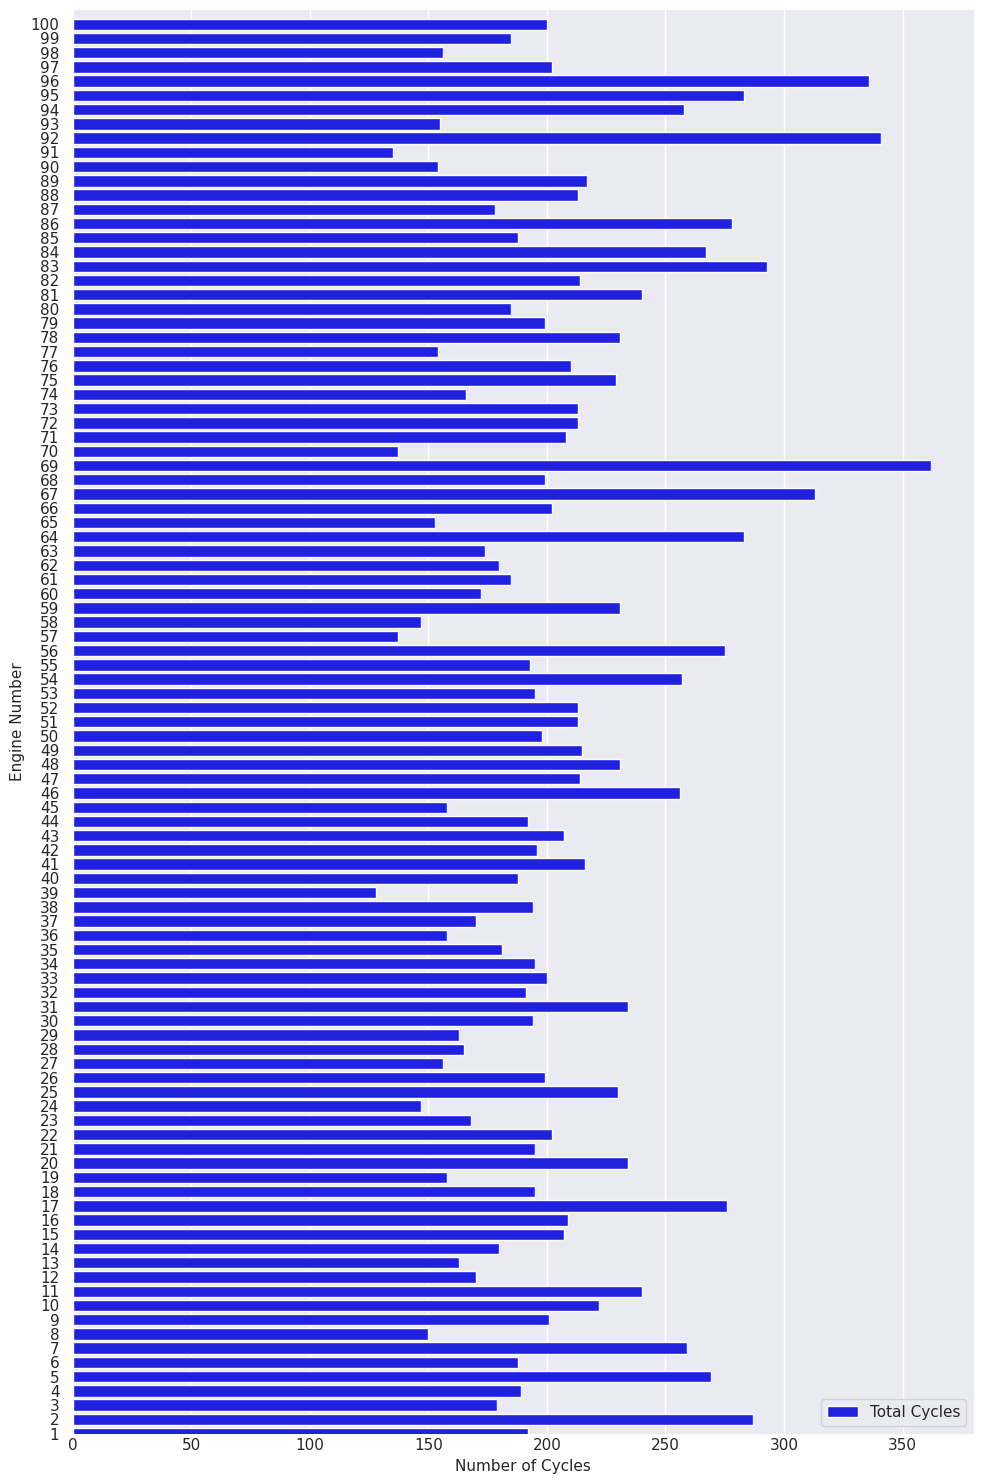

In [11]:
jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()

f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("pastel")
sns.barplot(x="cycle", y="id", data=jet_id_and_rul, label="Total Cycles", color="blue", orient = 'h', dodge=False)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylim=(0, 100), ylabel="",xlabel="Lifetime for each engine")
sns.despine(left=True, bottom=True)
ax.tick_params(labelsize=11)
ax.tick_params(length=0, axis='x')
ax.set_ylabel("Engine Number", fontsize=11)
ax.set_xlabel("Number of Cycles", fontsize=11)
plt.tight_layout()
plt.show()

Mean number of cycles after which jet engine fails is 206


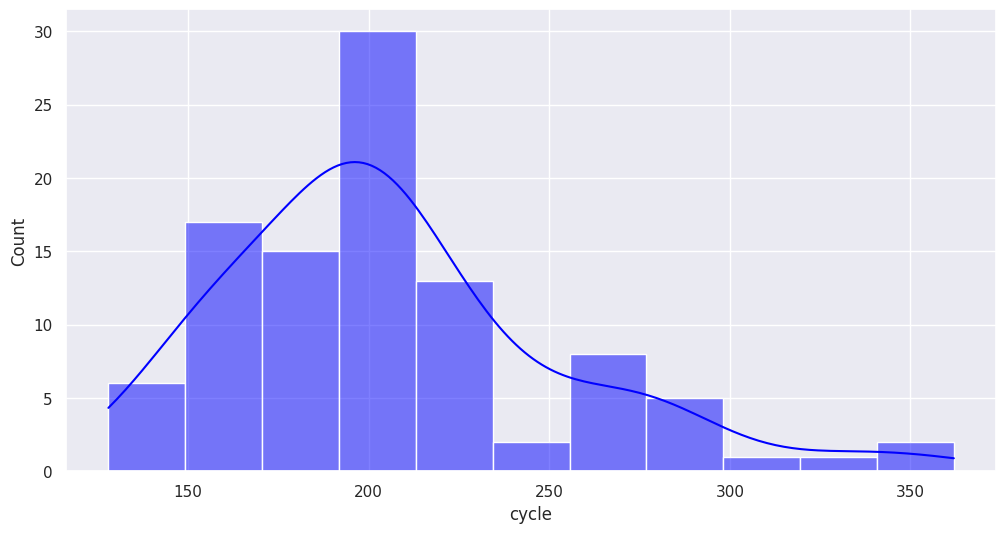

In [12]:
plt.subplots(figsize=(12, 6))
sns.histplot(jet_id_and_rul["cycle"], kde = True, color='blue');
print("Mean number of cycles after which jet engine fails is "+ str(math.floor(jet_id_and_rul["cycle"].mean())))

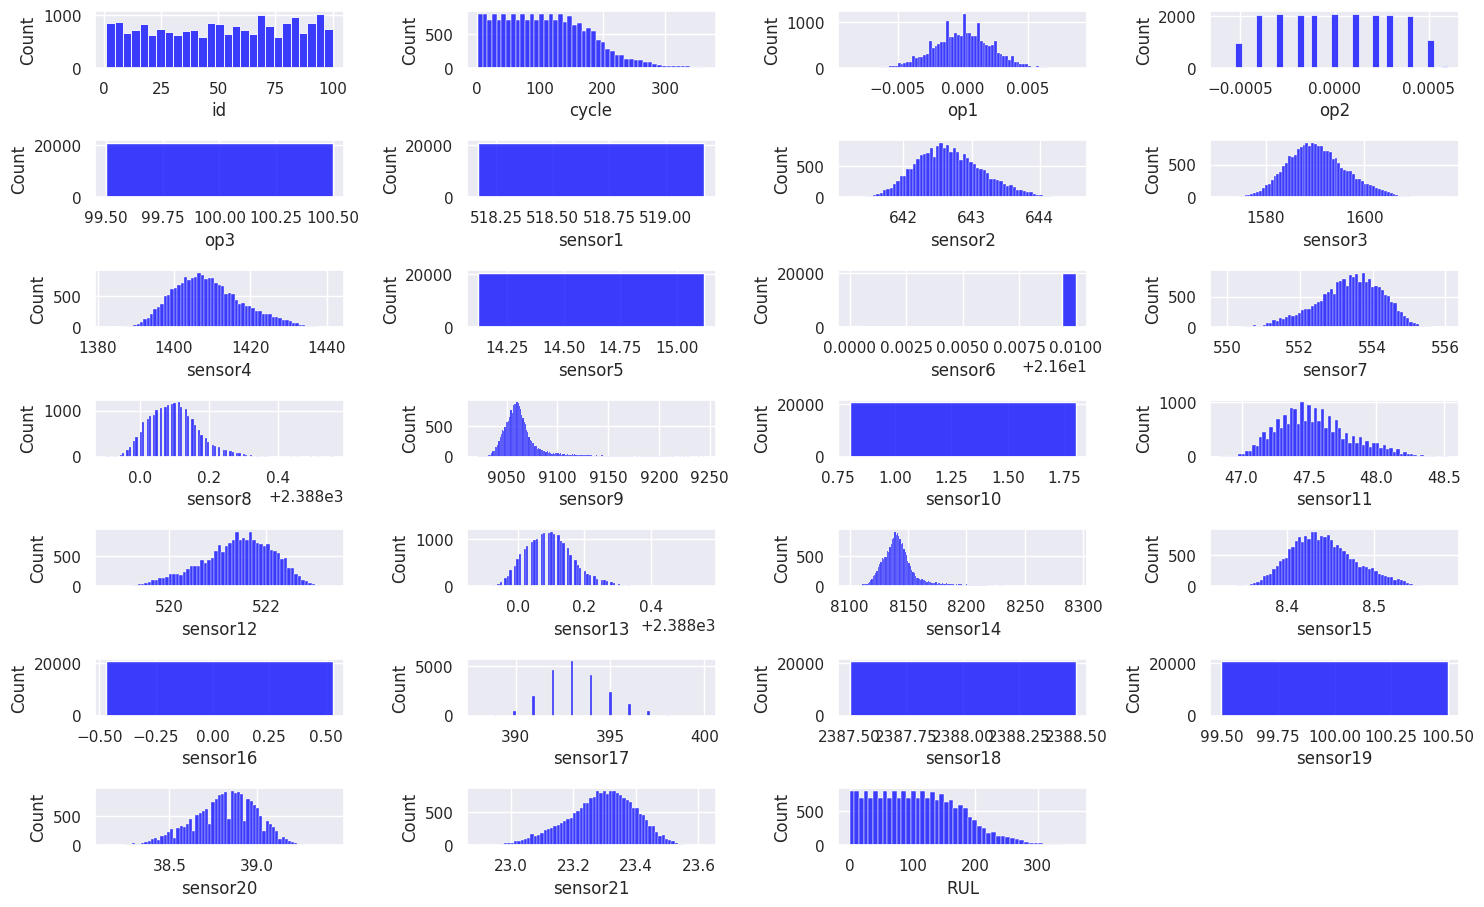

In [13]:
#Histogram representation of each sensor data

sns.set()
fig = plt.figure(figsize = [15,10])
cols = jet_data.columns
cnt = 1
for col in cols :
    plt.subplot(8,4,cnt)
    sns.histplot(jet_data[col],color='blue')
    cnt+=1
plt.tight_layout()
plt.show()

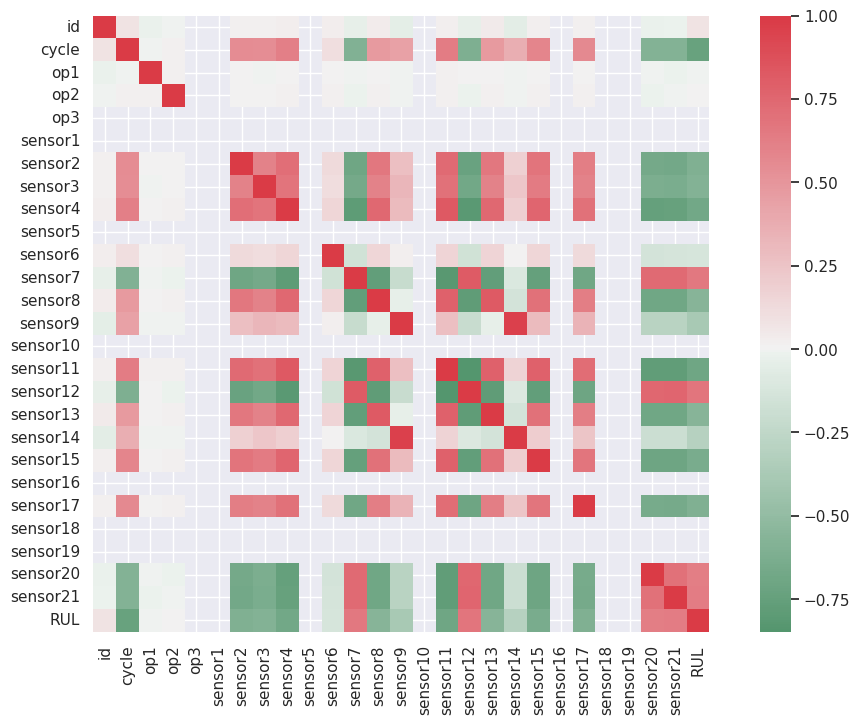

In [14]:
plt.figure(figsize=(13,8))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_data.corr(), cmap =cmap, center=0, annot=False, square=True);

In [15]:
jet_relevant_data = jet_data.drop(["cycle", "op1", "op2", "op3", "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19", "sensor14", "sensor13", "sensor12", "sensor11"], axis=1)

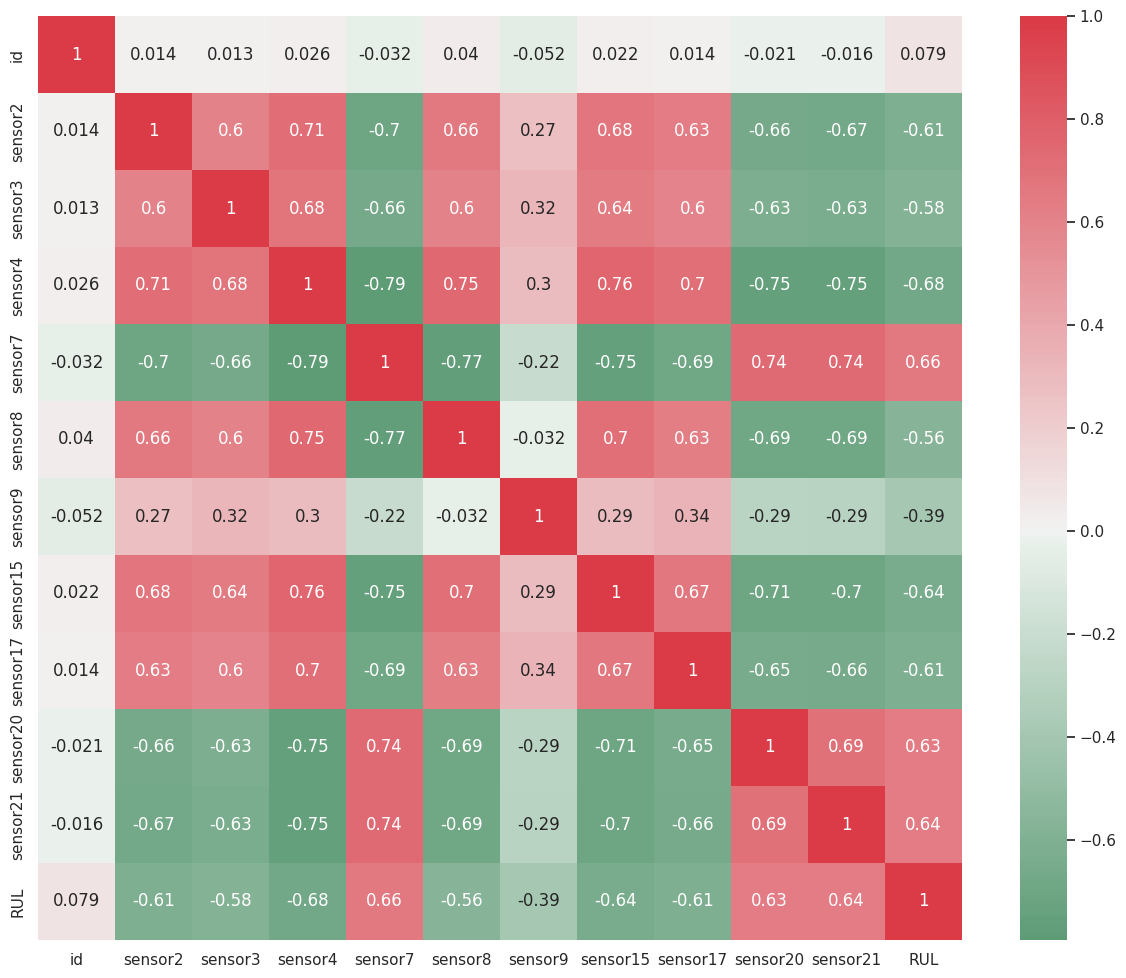

In [16]:
plt.figure(figsize=(15, 12))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_relevant_data.corr(), cmap =cmap, center=0, annot=True, square=True);

## Data treatment


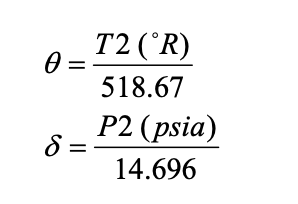

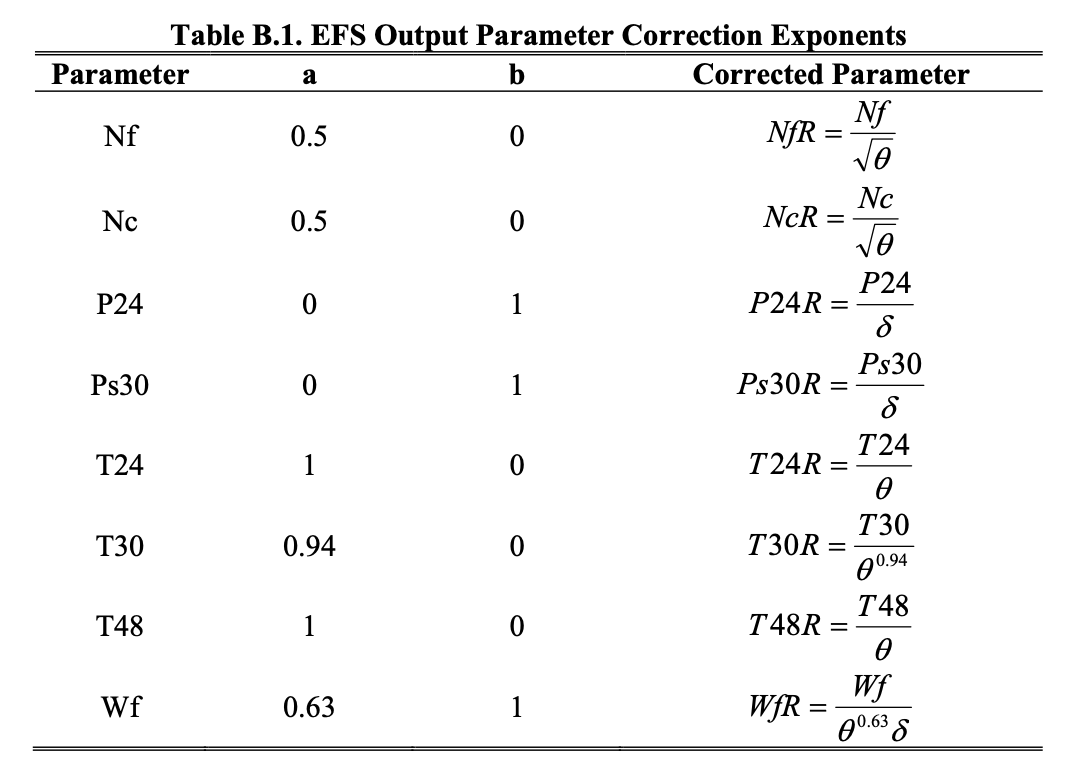

In [17]:
jet_data_corrected = jet_data.copy()
jet_data_corrected["sensor2"] = jet_data_corrected["sensor2"]/(jet_data_corrected["sensor1"]/518.67)
jet_data_corrected["sensor3"] = jet_data_corrected["sensor3"]/((jet_data_corrected["sensor1"]/518.67)**0.94)
jet_data_corrected["sensor4"] = jet_data_corrected["sensor4"]/((jet_data_corrected["sensor1"]/518.67))
jet_data_corrected["sensor6"] = jet_data_corrected["sensor6"]/((jet_data_corrected["sensor5"]/14.696)**1)
jet_data_corrected["sensor7"] = jet_data_corrected["sensor7"]/((jet_data_corrected["sensor5"]/14.696)**1)
jet_data_corrected["sensor8"] = jet_data_corrected["sensor8"]/((jet_data_corrected["sensor1"]/518.67)**0.5)
jet_data_corrected["sensor9"] = jet_data_corrected["sensor9"]/((jet_data_corrected["sensor1"]/518.67)**0.5)
jet_data_corrected["sensor11"] = jet_data_corrected["sensor11"]/((jet_data_corrected["sensor5"]/14.696)**1)
jet_data_corrected["sensor13"] = jet_data_corrected["sensor13"]/((jet_data_corrected["sensor1"]/518.67)**0.5)
jet_data_corrected["sensor14"] = jet_data_corrected["sensor14"]/((jet_data_corrected["sensor1"]/518.67)**0.5)
jet_data_corrected["sensor18"] = jet_data_corrected["sensor18"]/((jet_data_corrected["sensor1"]/518.67)**0.5)
jet_data_corrected["sensor19"] = jet_data_corrected["sensor19"]/((jet_data_corrected["sensor1"]/518.67)**0.5)
jet_data_corrected["fuelflow"] = jet_data_corrected["sensor12"]*jet_data_corrected['sensor11']/(((jet_data_corrected["sensor5"]/14.696)**1)*((jet_data_corrected["sensor1"]/518.67)**0.63))


In [55]:
jet_data_corrected["sensor11"].head(10)

0    47.716766
1    47.736870
2    47.515726
3    47.374999
4    47.525778
5    47.405155
6    47.606194
7    47.485570
8    47.535830
9    47.274479
Name: sensor11, dtype: float64

## Trend monitoring

We'll consider first 10 cycles for each engine as baseline for healthy conditions

In [44]:
sensor_columns = jet_data_corrected.drop(['cycle','sensor1','sensor5','sensor10','sensor16','sensor18','sensor19','id','op1','op2','op3','RUL'], axis=1).columns
#sensor_columns = [col for col in jet_data_corrected.columns if col.startswith('sensor')]

baseline_list = []

for engine_id in jet_data_corrected['id'].unique():
    engine_data = jet_data_corrected[jet_data_corrected['id'] == engine_id]

    first_10_cycles = engine_data.nsmallest(10, 'cycle')

    baselines = first_10_cycles.mean(numeric_only=True)

    baselines['id'] = engine_id

    baseline_list.append(baselines)

baseline_data = pd.DataFrame(baseline_list)

baseline_data = baseline_data[jet_data_corrected.columns]

In [45]:
baseline_data.drop(columns=['cycle','op1','op2','op3'], inplace=True)

In [46]:
baseline_data.head()

id  sensor1  sensor2   sensor3   sensor4  sensor5    sensor6     sensor7  \
0  1.0   518.67  642.201  1587.712  1400.840    14.62  21.722337  556.976390   
1  2.0   518.67  641.852  1584.615  1396.464    14.62  21.717311  557.643841   
2  3.0   518.67  642.406  1582.337  1399.163    14.62  21.722337  557.281970   
3  4.0   518.67  642.411  1586.074  1403.367    14.62  21.722337  556.617534   
4  5.0   518.67  642.183  1584.659  1394.622    14.62  21.720326  557.625748   

    sensor8   sensor9  ...  sensor14  sensor15  sensor16  sensor17  sensor18  \
0  2388.049  9049.560  ...  8132.228   8.40839      0.03     391.8    2388.0   
1  2388.015  9054.954  ...  8137.833   8.39211      0.03     391.0    2388.0   
2  2388.035  9055.542  ...  8137.689   8.41055      0.03     391.7    2388.0   
3  2388.065  9049.965  ...  8131.746   8.41789      0.03     392.3    2388.0   
4  2387.989  9067.618  ...  8149.014   8.40206      0.03     391.7    2388.0   

   sensor19  sensor20  sensor21    RUL      fuelflow  
0     100.0    38.984  23.38960  186.5  24940.170484  
1     100.0    39.104  23.46430  281.5  24886.981324  
2     100.0    38.980  23.39100  173.5  24901.208767  
3     100.0    38.934  23.36801  183.5  24963.002110  
4     100.0    39.116  23.39646  263.5  24909.016948  

[5 rows x 24 columns]

In [49]:
id_cycle_columns = ['id', 'cycle', 'op1', 'op2', 'op3']
#sensor_columns = [col for col in jet_data_corrected.columns if col.startswith('sensor')]
sensor_columns = jet_data_corrected.drop(['cycle','sensor1','sensor5','sensor10','sensor16','sensor18','sensor19','id','op1','op2','op3','RUL'], axis=1).columns

merged_data = pd.merge(jet_data_corrected, baseline_data, on='id', suffixes=('', '_baseline'))

trend_data = merged_data[id_cycle_columns].copy()

for sensor in sensor_columns:
    trend_data[sensor] = merged_data[sensor] - merged_data[f"{sensor}_baseline"]


In [50]:
trend_data.head()

id  cycle     op1     op2    op3  sensor2  sensor3  sensor4       sensor6  \
0   1      1 -0.0007 -0.0004  100.0   -0.381    1.988    -0.24 -3.552714e-15   
1   1      2  0.0019 -0.0003  100.0   -0.051    4.108     2.30 -3.552714e-15   
2   1      3 -0.0043  0.0003  100.0    0.149    0.278     3.36 -3.552714e-15   
3   1      4  0.0007  0.0000  100.0    0.149   -4.922     1.03 -3.552714e-15   
4   1      5 -0.0019 -0.0002  100.0    0.169   -4.862     5.38 -3.552714e-15   

    sensor7  ...  sensor9  sensor11  sensor12  sensor13  sensor14  sensor15  \
0  0.265372  ...    -3.37  0.199029    -0.486    -0.024     6.392   0.01111   
1 -0.347799  ...    -5.49  0.219133     0.134     0.026    -0.738   0.02341   
2  0.164853  ...     3.38 -0.002010     0.274    -0.014     1.002   0.00941   
3  0.355840  ...    -0.08 -0.142738     0.714     0.036     1.602  -0.04019   
4 -0.096499  ...     5.59  0.008042     0.044    -0.004     1.572   0.02101   

   sensor17  sensor20  sensor21    fuelflow  
0       0.2     0.076    0.0294   81.154870  
1       0.2     0.016    0.0340  121.447538  
2      -1.8    -0.034   -0.0454   12.035016  
3       0.2    -0.104   -0.0157  -40.912805  
4       1.2    -0.084    0.0148    6.325919  

[5 rows x 21 columns]

In [51]:
def plot_sensor(sensor_name, X):
    plt.figure(figsize=(13,5))
    for i in X['id'].unique():
        if (i % 10 == 0):  # only plot every engine
            # Use 'cycle' as the x-axis data instead of 'Cycle' string
            plt.plot('cycle', sensor_name,
                     data=X[X['id']==i].rolling(8).mean())
            plt.axvline(30, color='red', linestyle='dashed', linewidth=2)
    #plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Cycle')
    plt.show()

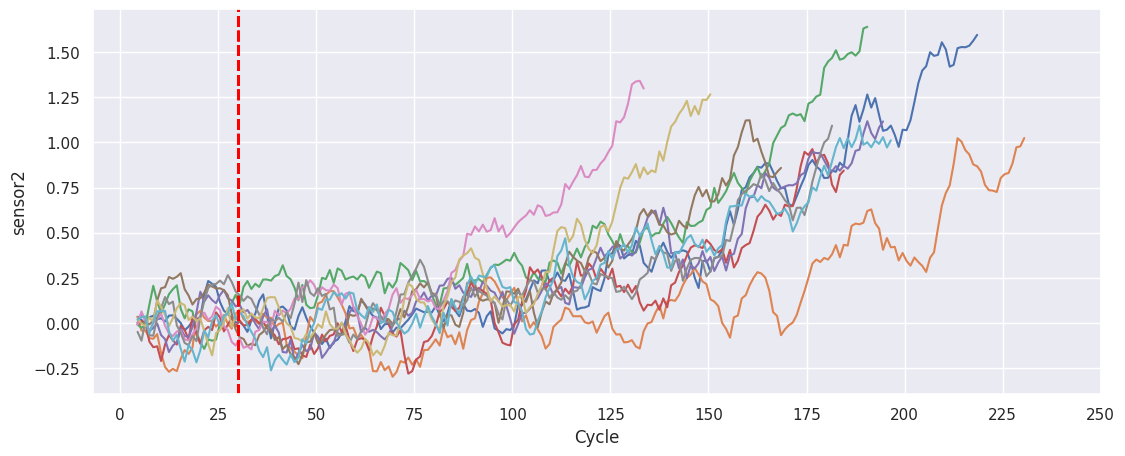

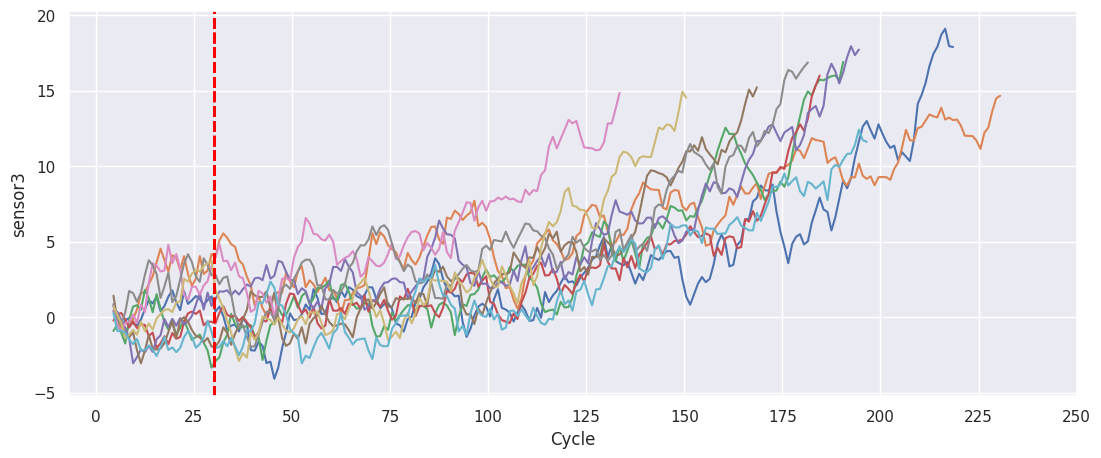

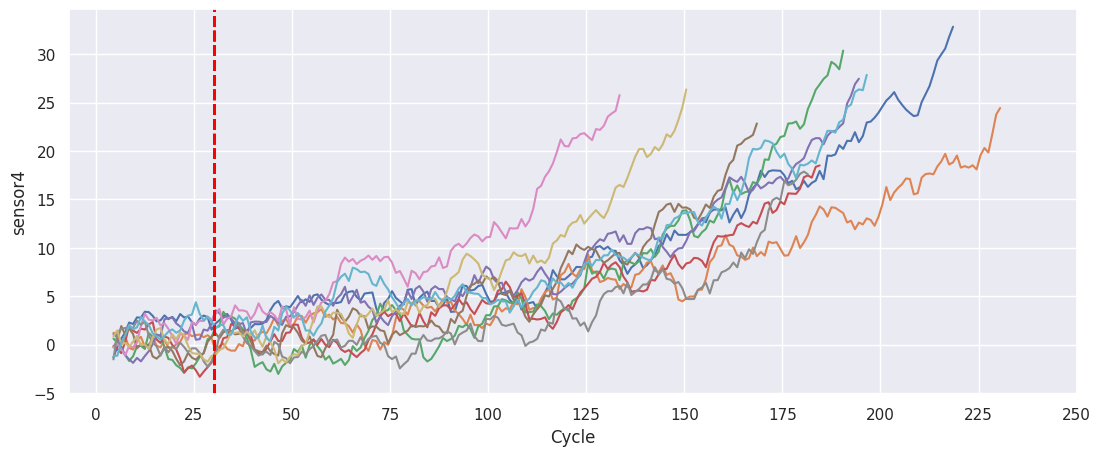

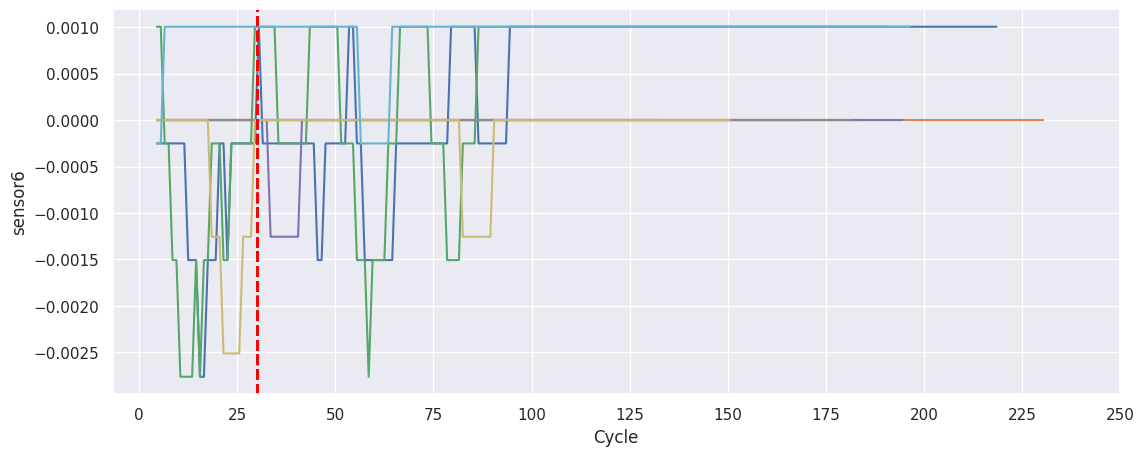

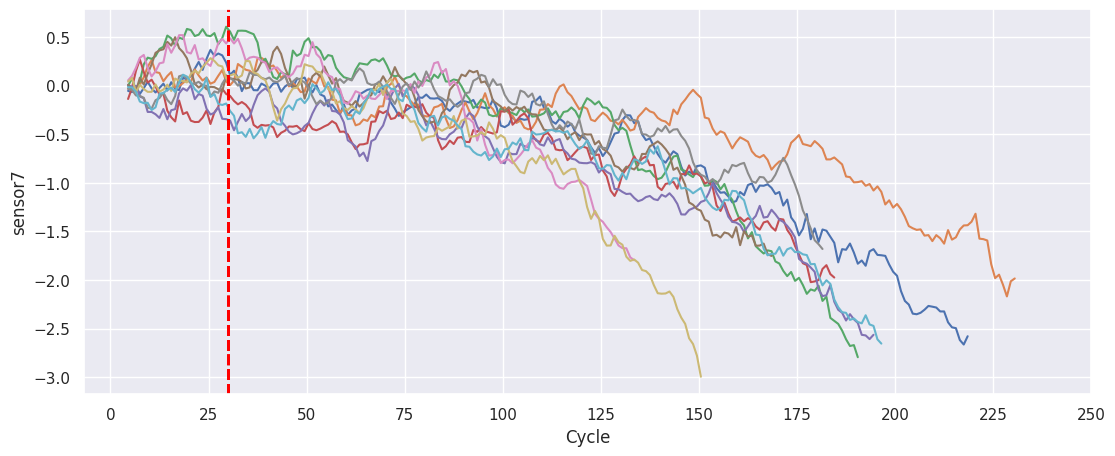

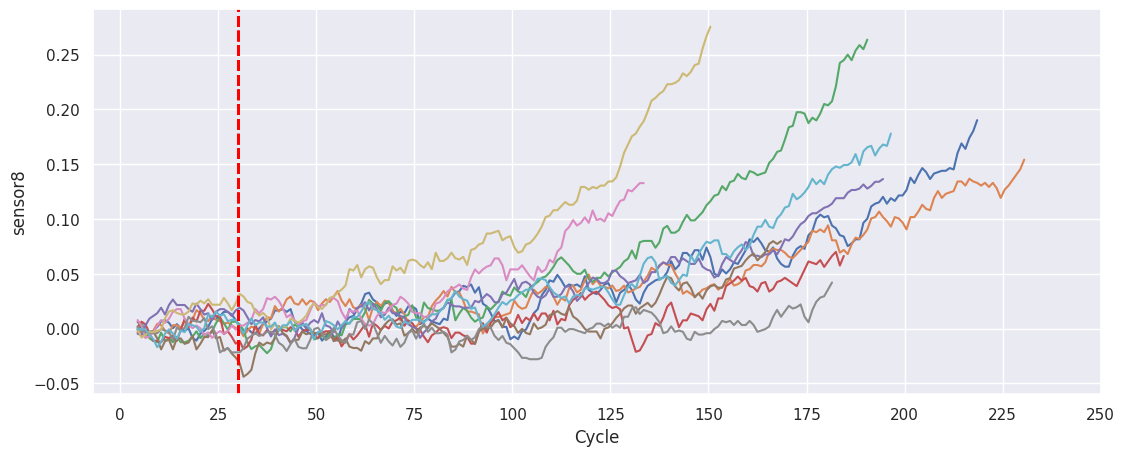

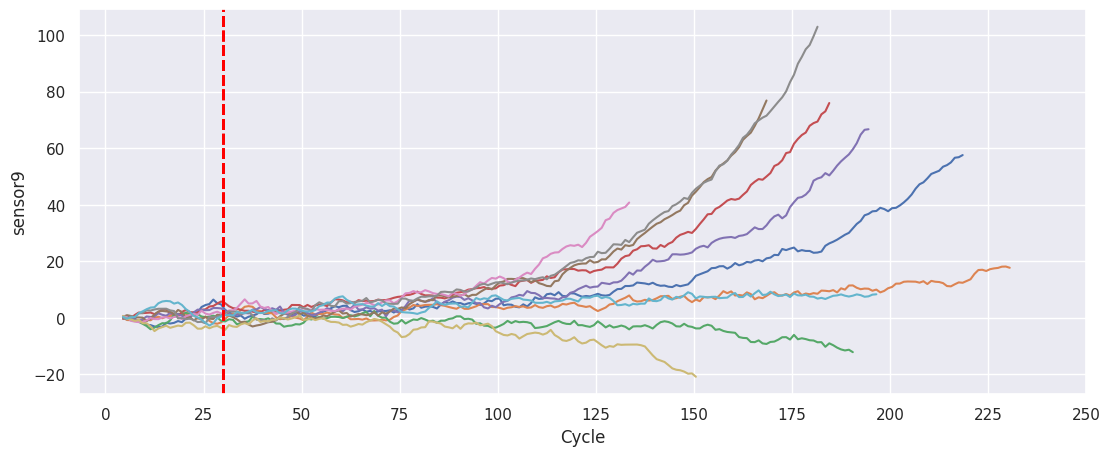

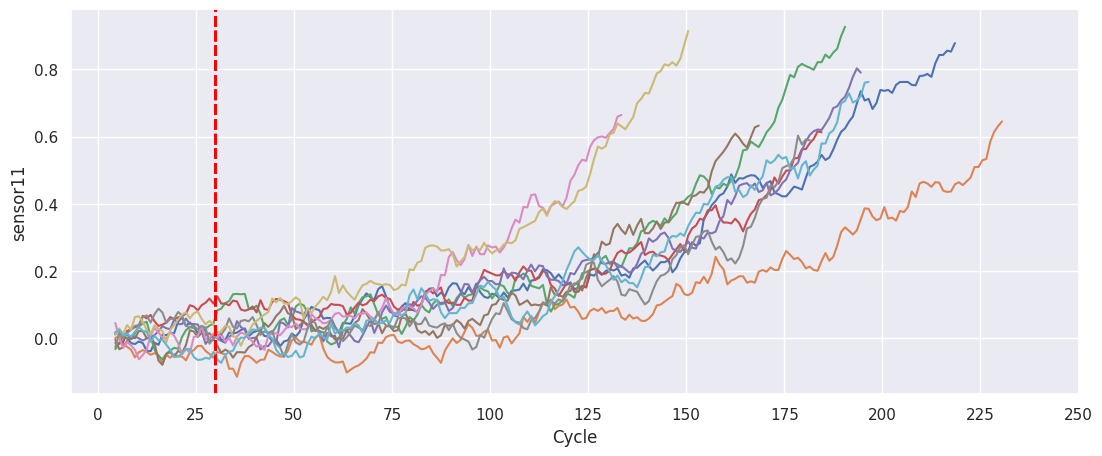

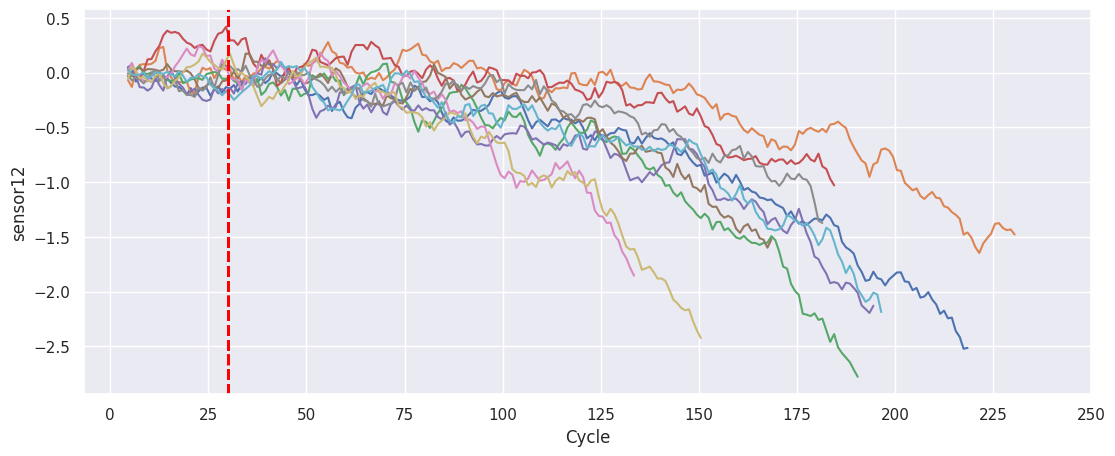

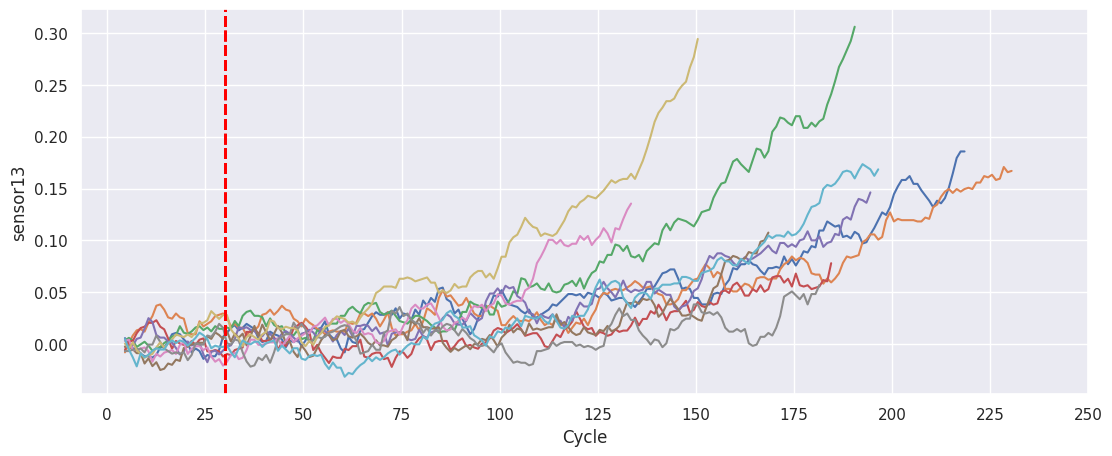

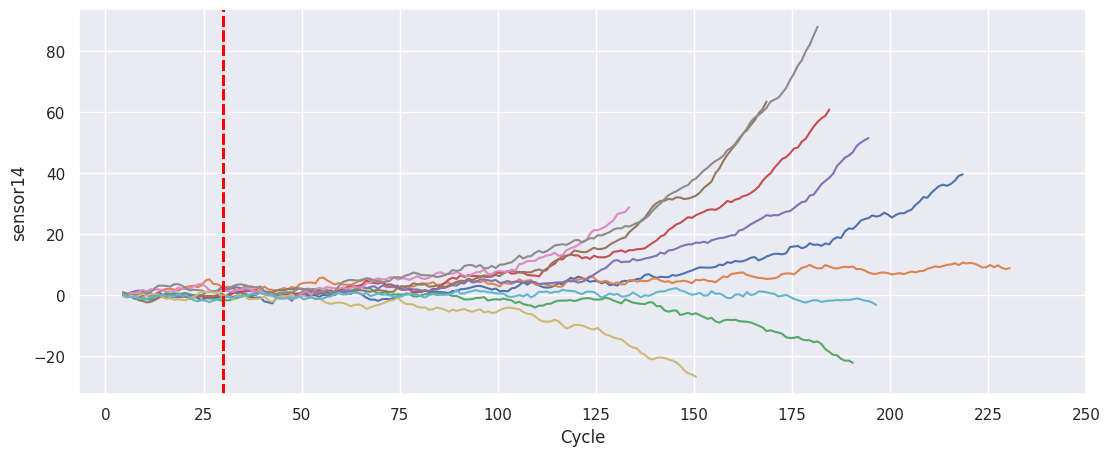

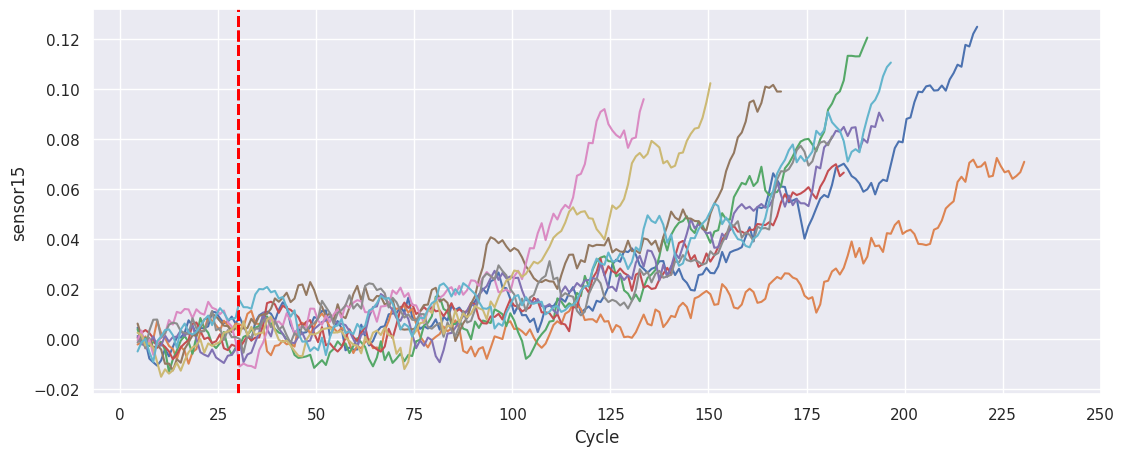

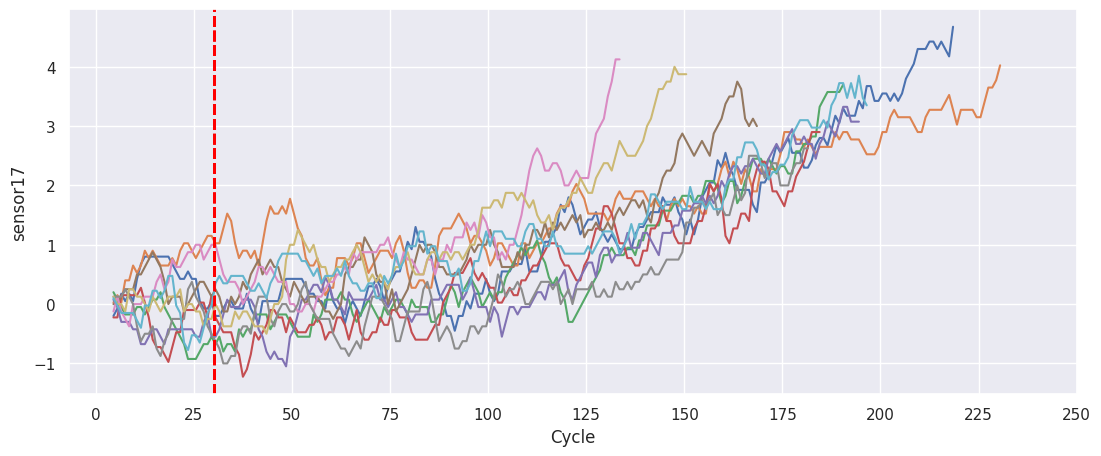

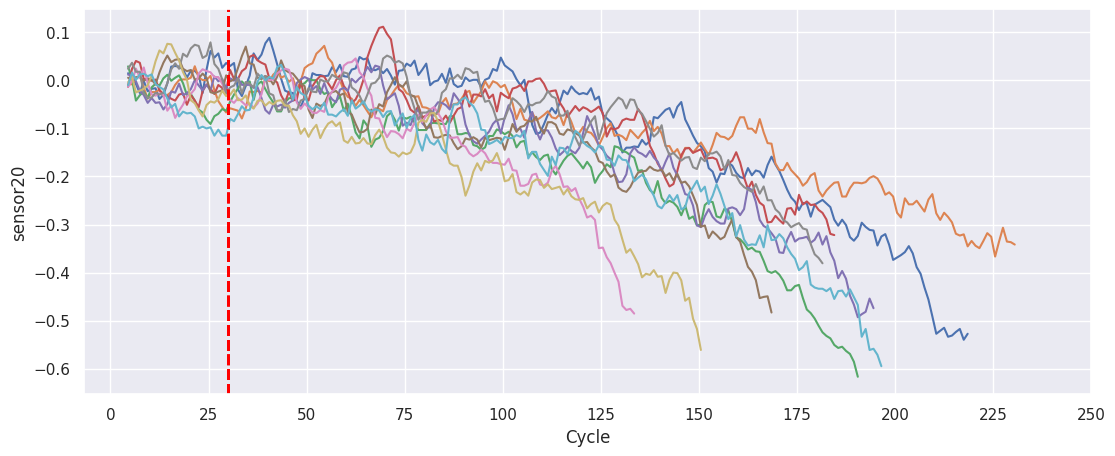

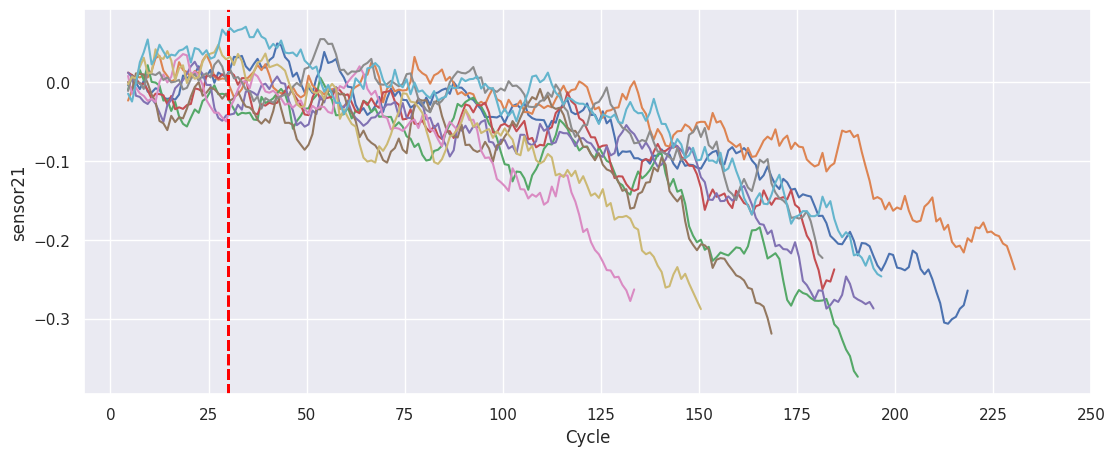

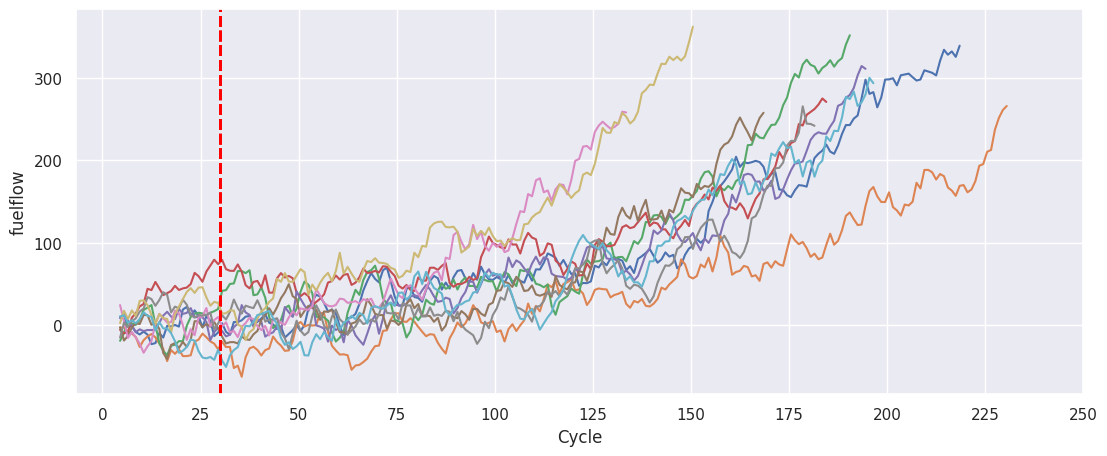

In [53]:
for sensor in trend_data.drop(['cycle','id','op1','op2','op3'], axis=1).columns:
    plot_sensor(sensor, trend_data)

Implement exponential moving average

In [56]:
sensor_columns = jet_data_corrected.drop(['cycle','sensor1','sensor5','sensor10','sensor16','sensor18','sensor19','id','op1','op2','op3','RUL'], axis=1).columns

alpha = 0.8844 #smoothing factor (alpha)

ema_data = trend_data[['id', 'cycle']].copy()

for sensor in sensor_columns:
    ema_values = []

    for engine_id in trend_data['id'].unique():
        engine_data = trend_data[trend_data['id'] == engine_id]

        ema = engine_data[sensor].iloc[0]
        ema_values_engine = [ema]  # Start with the first EMA value

        for k in range(1, len(engine_data)):
            delta_y = engine_data[sensor].iloc[k]
            ema = alpha * ema + (1 - alpha) * delta_y
            ema_values_engine.append(ema)

        ema_values.extend(ema_values_engine)

    ema_data[f'{sensor}_ema'] = ema_values

In [57]:
ema_data.head()

id  cycle  sensor2_ema  sensor3_ema  sensor4_ema   sensor6_ema  \
0   1      1    -0.381000     1.988000    -0.240000 -3.552714e-15   
1   1      2    -0.342852     2.233072     0.053624 -3.552714e-15   
2   1      3    -0.285994     2.007066     0.435841 -3.552714e-15   
3   1      4    -0.235709     1.206066     0.504526 -3.552714e-15   
4   1      5    -0.188924     0.504597     1.068131 -3.552714e-15   

   sensor7_ema  sensor8_ema  sensor9_ema  sensor11_ema  sensor12_ema  \
0     0.265372     0.011000    -3.370000      0.199029     -0.486000   
1     0.194490     0.008688    -3.615072      0.201353     -0.414328   
2     0.191064     0.011267    -2.806442      0.177844     -0.334757   
3     0.210112     0.017016    -2.491265      0.140785     -0.213521   
4     0.174668     0.016321    -1.557071      0.125440     -0.183752   

   sensor13_ema  sensor14_ema  sensor15_ema  sensor17_ema  sensor20_ema  \
0     -0.024000      6.392000      0.011110      0.200000      0.076000   
1     -0.018220      5.567772      0.012532      0.200000      0.069064   
2     -0.017732      5.039969      0.012171     -0.031200      0.057150   
3     -0.011521      4.642540      0.006118     -0.004473      0.038521   
4     -0.010651      4.287585      0.007840      0.134764      0.024357   

   sensor21_ema  fuelflow_ema  
0      0.029400     81.154870  
1      0.029932     85.812703  
2      0.021223     77.284002  
3      0.016955     63.620451  
4      0.016706     56.997203

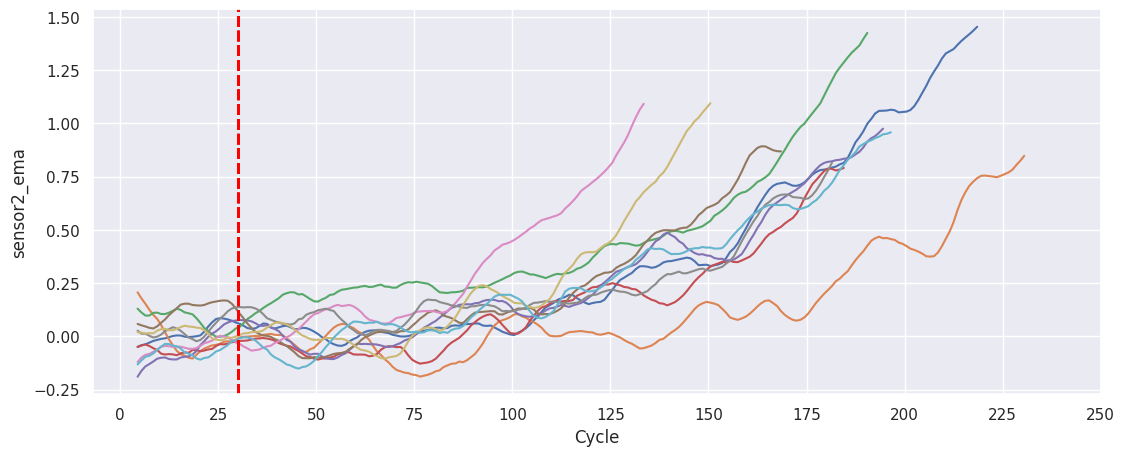

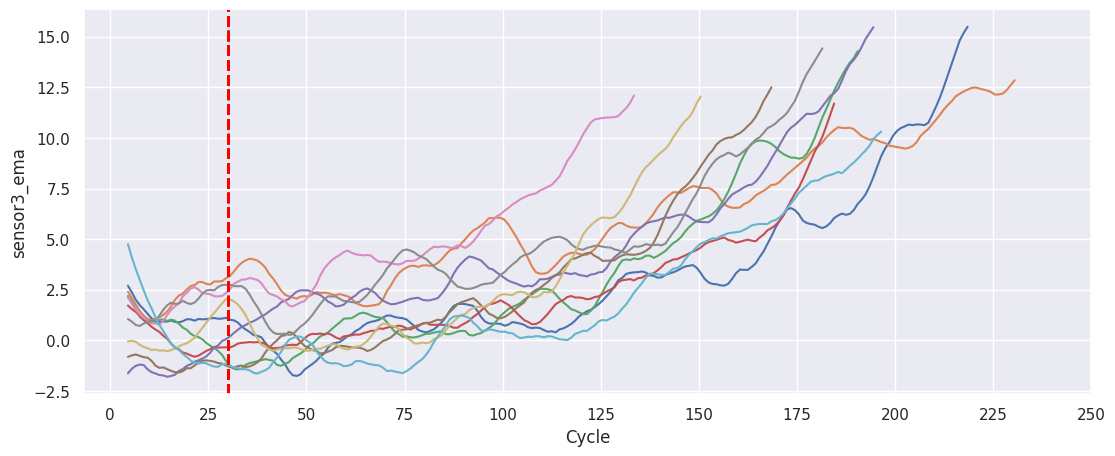

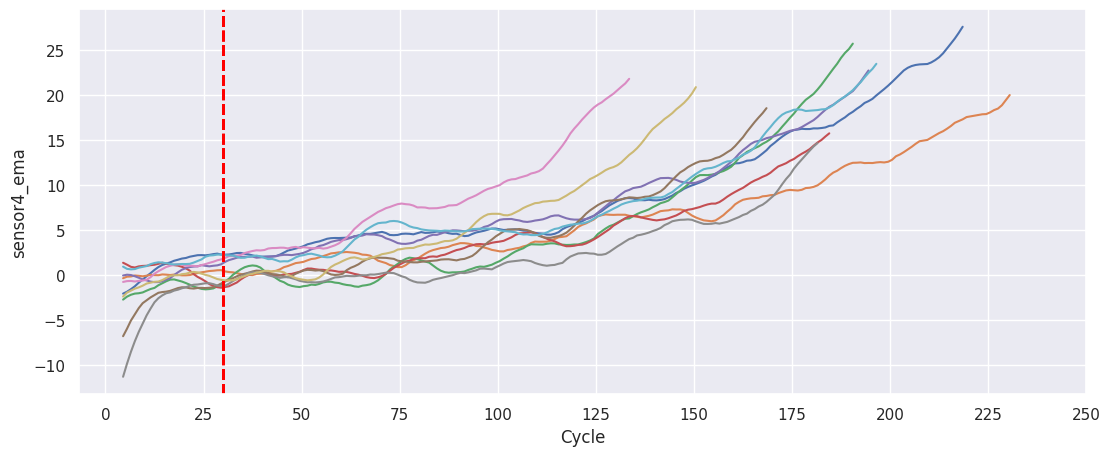

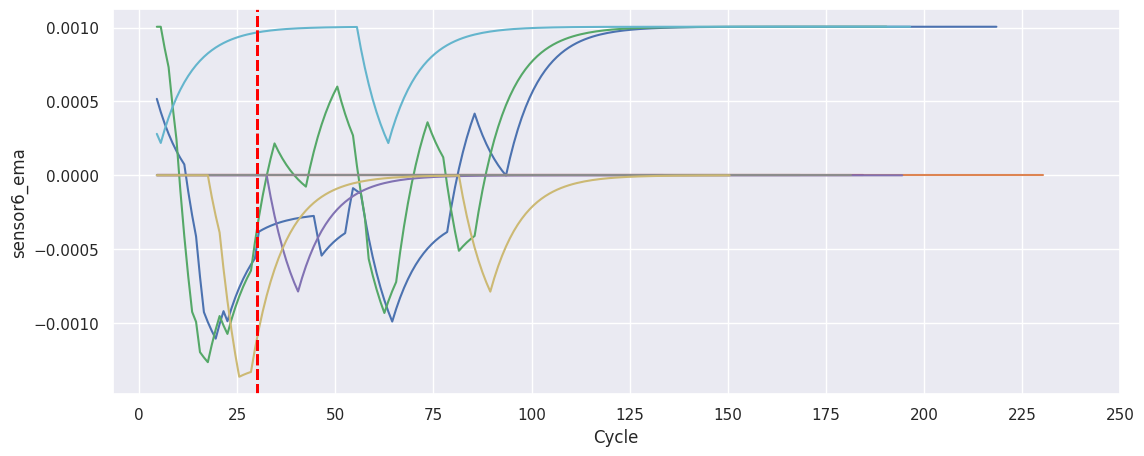

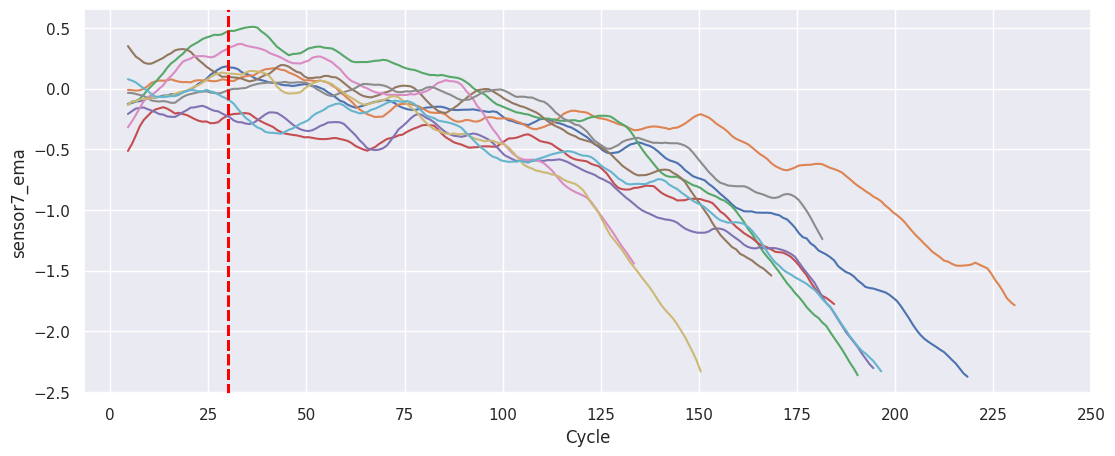

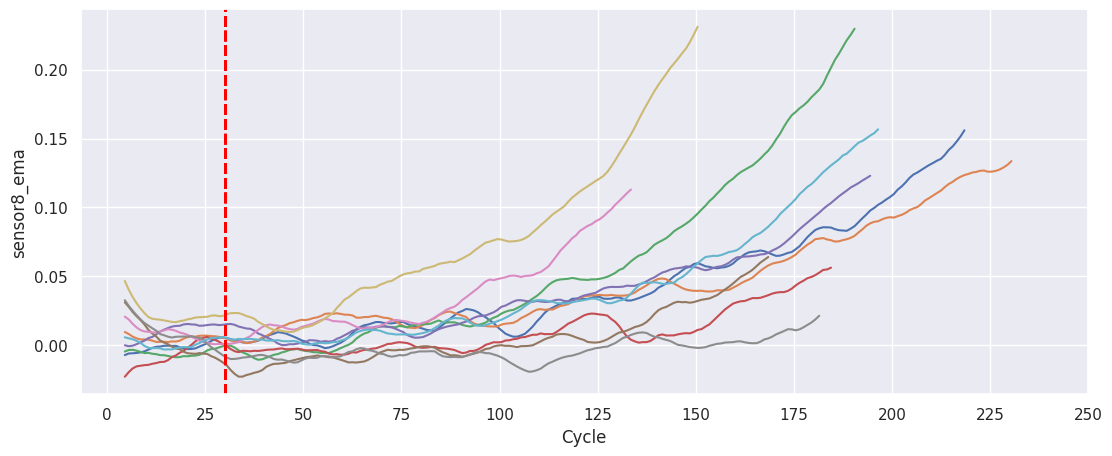

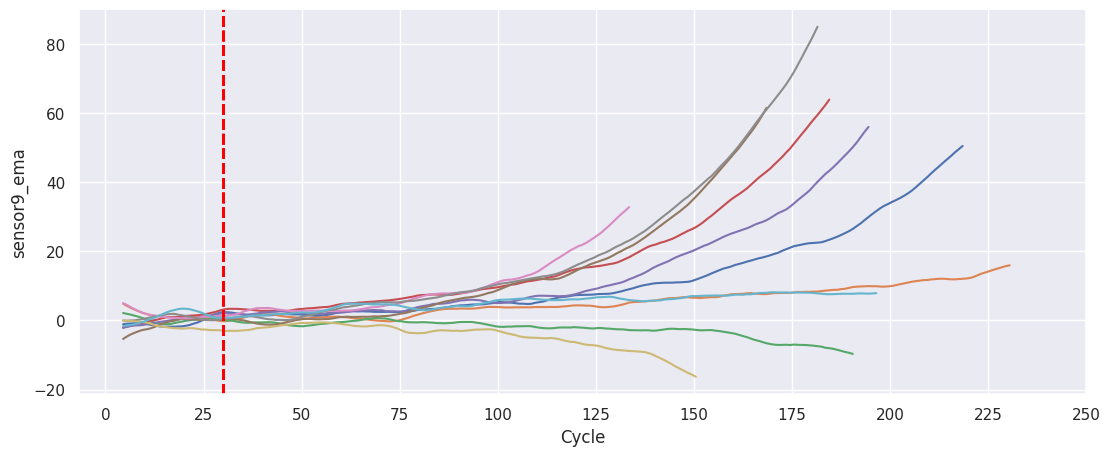

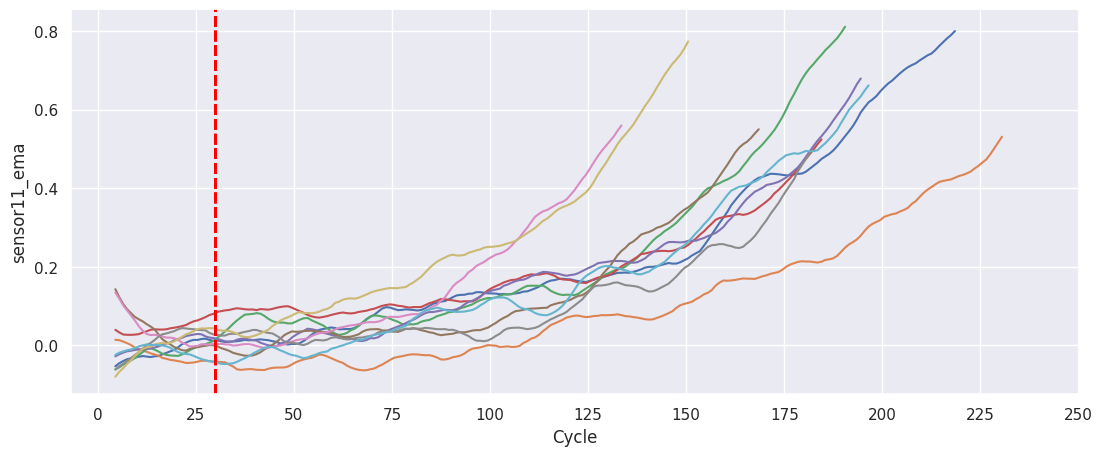

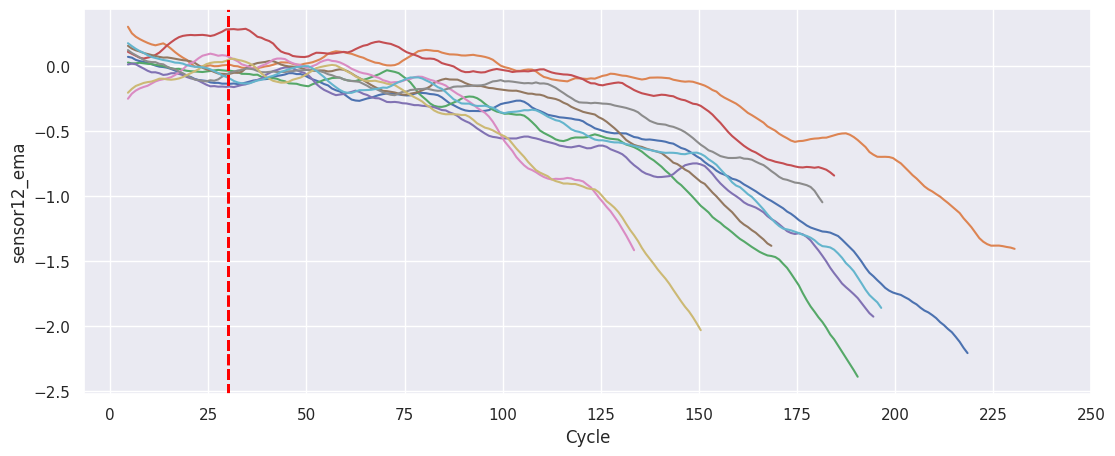

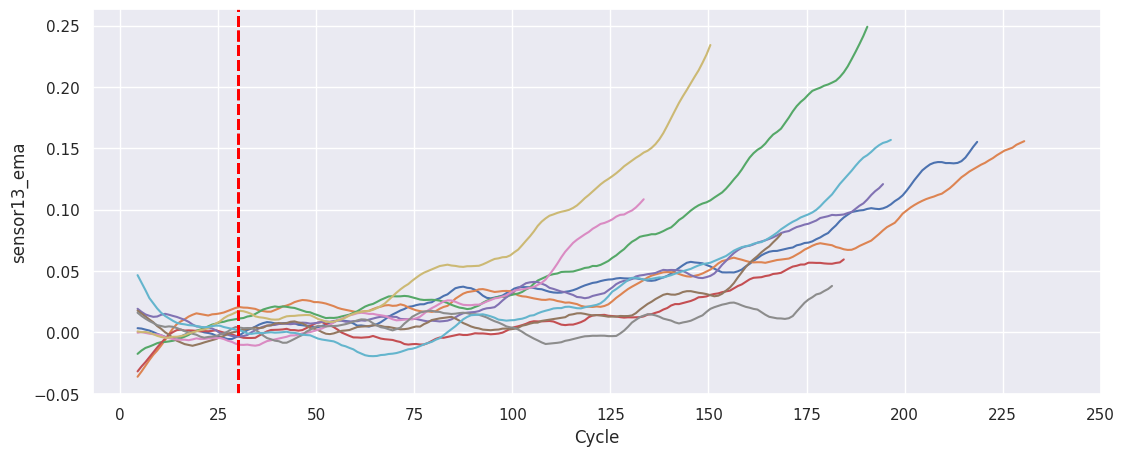

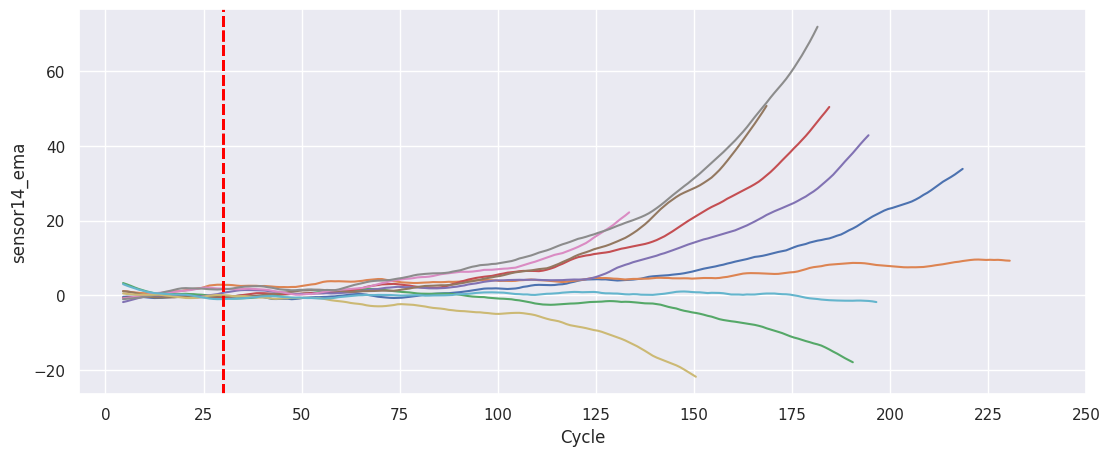

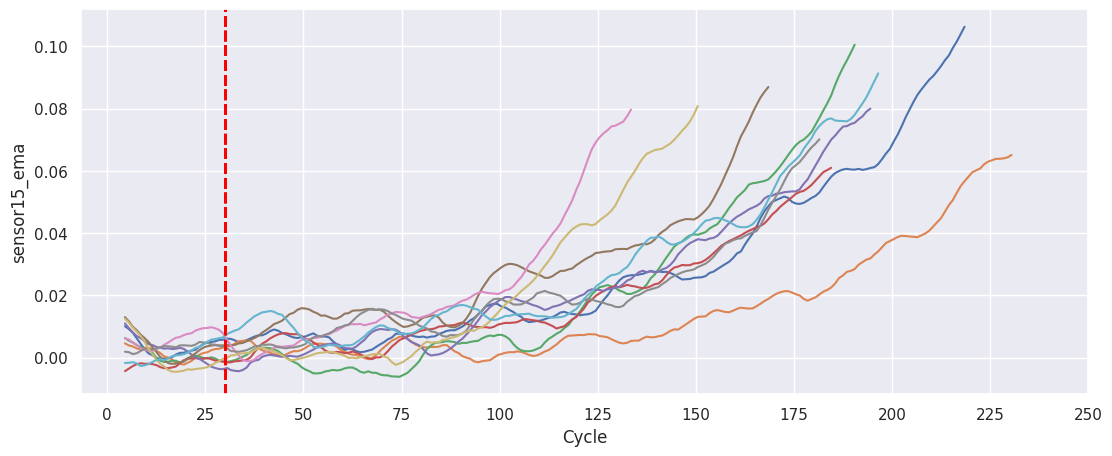

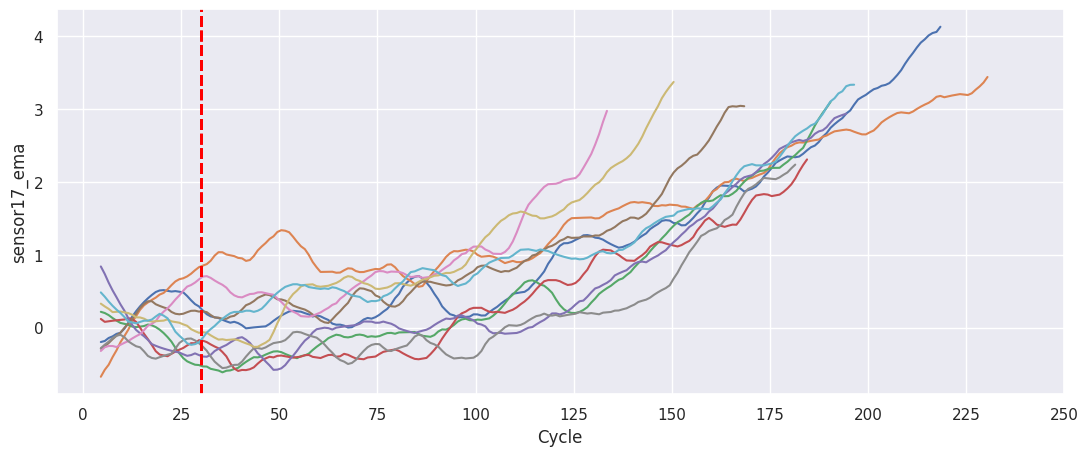

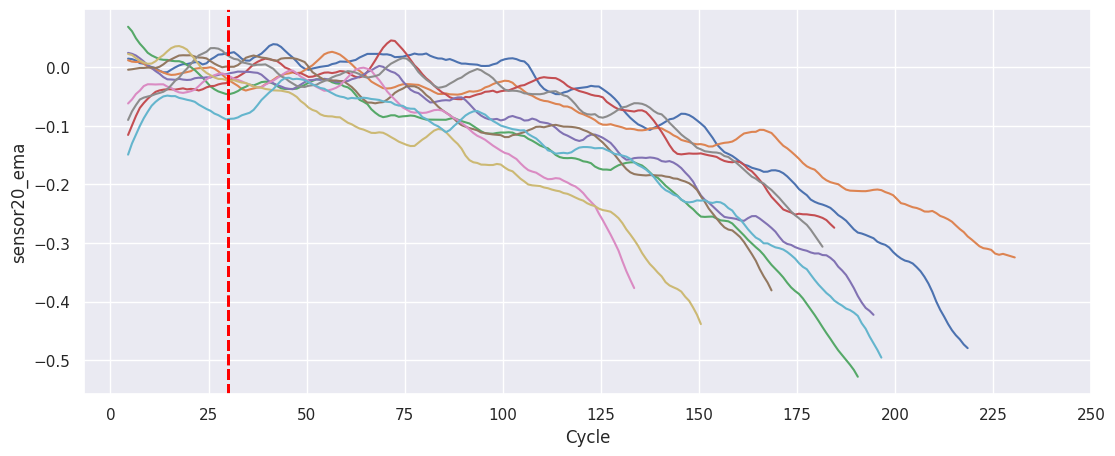

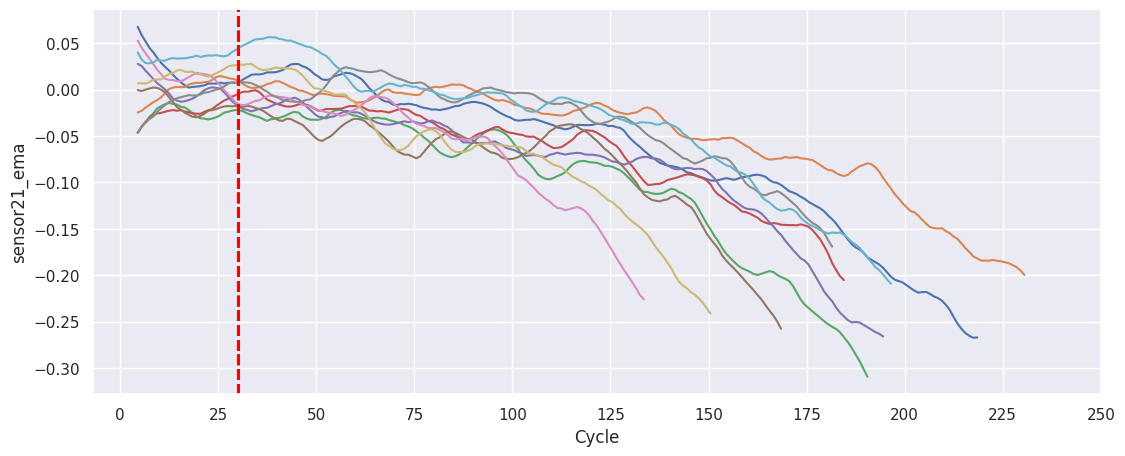

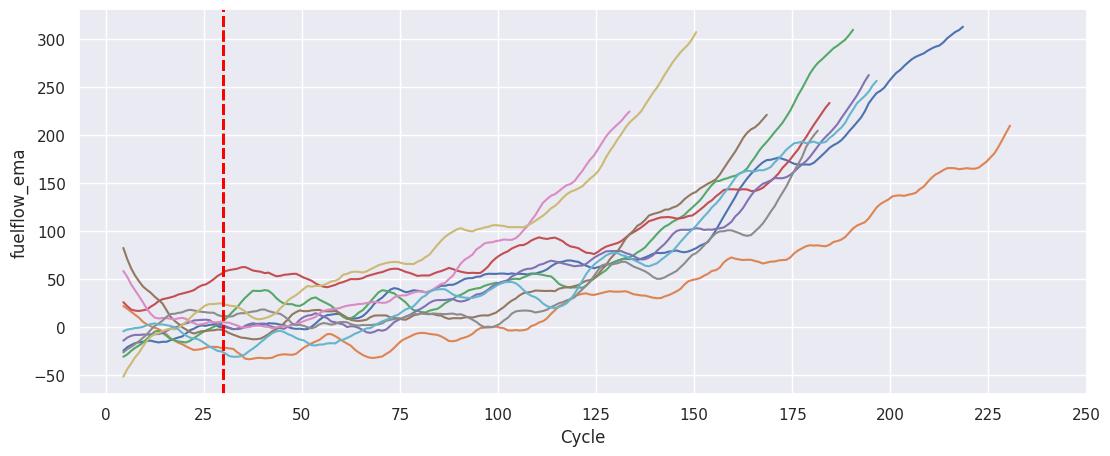

In [60]:
for sensor in ema_data.drop(['cycle','id'], axis=1).columns:
    plot_sensor(sensor, ema_data)

## Anomaly detection